# Homework 3 - Pakes 1986
Solutions to ECO 384k Problem set 3 at the Universtiy of Texas by Eric Schulman

In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.stats import expon #need to use scipy stats for scale
from scipy.stats import binom
from scipy.interpolate import interp1d #pre written interpolation function

## Part 1 -  Parameter Set up

The following code sets up the parameters for the model. Here we define

* $\mu$, $\sigma$ - initial mean and variance of the patents' value
* $\sigma$ - the base variance of $z$ (a new complementary innovation)  
* $\gamma$ - mean for the distribution on $z$
* $\phi$ - scales up the variance of $z$ based on the amount of periods that have passed
* $\delta$ - scales down $r_a$, the revenue at date $a$, when simulating $r_{a+1}$
* $\theta$ - probability involved with tomorrow's revenue $r_{a+1}$ being non-zero

In [2]:
#load data from schedule/coefficients
coef = pd.read_csv('coef.csv',index_col=0)
schedule = pd.read_csv('schedule.csv')

#set up global variables
TIME = 20
BETA = .99

SIGMA, GAMMA, PHI, DELTA, SIGMA_R, MU,THETA = coef['france']
NSIM = 200

sched_1 =  np.array(schedule['sched_1'])
sched_2 =  np.array(schedule['sched_2'])

## Part 2 - Calculating the Value function

The following code is designed to calculate the value function using backward recursion.

$$V(a,r_a) = max(0, r_a - c_a + \beta \int V(a+1, r_{a+1})G(r_{a+1}|r_a,a))$$

Although I technically only need to know previous period's value function for the purposes of calculating the current period, I save each periods value function for the purposes of creating graphs.

Additionally, I take the same simulation draws across each state when simulating $E(V(a+1,r_{a+1}))$ so that the value function is smooth. Since $z$ does not depend on state $r_a$, I can use the same $z$ draws for all states. To simulate the binomal probability $exp(-\theta r_a)$, I take uniform draws. I compare the same draws accross all states $r_a$ to the 'cutoff value'  $exp(-\theta r_a)$ associated with state $r_a$. This works as if I took draws from the binomial distribution with probability $exp(-\theta r_a)$.

In [3]:
def memoize_value(sched, l, max_r, grid):
    """memioze the value funcion l periods into the past"""
    
    #set up states
    states = np.array(range(0,max_r,grid))
    
    if l == TIME: #if we are in the last period
        V = [np.maximum( 0, states - sched[l-2])]
        return np.array(V)
        
    elif l >= 2 and l < 20:
        
        #calculate the value function this period (and interpolate)
        V = memoize_value(sched,l+1,max_r, grid)
        V0 = interp1d(states, V[0],fill_value="extrapolate")
        
        #set up r_a as a 3d array to use with simulations
        ra = states.reshape(max_r/grid,1)
        ra = np.tile(ra, (1,NSIM))
        
        #caclulate value of innovation 'z' for each state in each simulation
        sigma_l = SIGMA * PHI**(l-1)
        z_sim = expon(loc= -GAMMA, scale= sigma_l ).rvs(size=(1,NSIM))
        z_sim = np.tile(z_sim, (max_r/grid,1)) #the same draws for each state
        
        #set up cutoff pr for binomial draws
        cutoff_pr = np.exp(-THETA*ra)
        
        #set up uniform draws to compare with cutoff
        binom_draws = np.random.uniform(0, 1, size=(1,NSIM))
        binom_draws = np.tile(binom_draws, (max_r/grid,1)) #the same draws
        binom_draws =  (binom_draws > cutoff_pr).astype(int)
        
        #set up value of ra in next period
        ra_next = np.maximum( DELTA*ra, z_sim)
        ra_next = binom_draws*ra_next
        
        #calculate the expected value function next period
        EV_next = V0(ra_next)
        EV_next = EV_next.mean(axis=1)
        
        #calculate the value funciton this period, uisn g
        V_update = np.maximum( 0, states + BETA*EV_next - sched[l-2]).reshape(1,max_r/grid)
        V = np.concatenate( (V_update , V), axis=0)
        return V
    else:
        print 'Index out of Bounds'
        return None

In [4]:
def find_cutoffs(V):
    """find the sequence of cutoff values"""
    cutoffs = []
    
    for l in range(len(V)):
        for r in range(len(V[l])):
            if V[l][r] > 0:
                cutoffs.append((r)*GRID)
                break
    return cutoffs

## Part 3 - Value Function and Optimal Schedule

Below I calculate the value function and cutoffs for the various schedules using France's parameters. Note that for low $r_{a}$ in the initial period, the value function is more prone to simulation error. This is because the future value can change based on the value of the simulated binomial draws for $r_{a+1}$. Getting a value of 0 is more impactful in these early stages

### Section 1 - Linear Fee Schedule

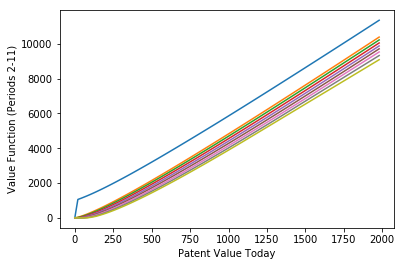

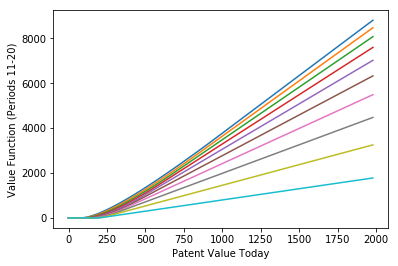

In [5]:
SCHED =  np.array(schedule['sched_1'])
MAX_R = 2000
GRID = 20
STATES = np.array(range(0,MAX_R,GRID))

#graph value function - Schedule 1
V =  memoize_value(sched_1,2,MAX_R,GRID)

#period's 1-9
fig = plt.figure()
for i in range(9):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 2-11)')

#periods 9-18
fig = plt.figure()
for i in range(9,19):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 11-20)');

Cutoff Vales: [20, 20, 20, 20, 40, 40, 60, 80, 80, 100, 120, 120, 140, 140, 160, 180, 180, 200, 220]


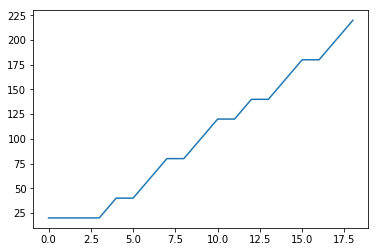

In [6]:
#graph cutoffs function - Schedule 1
cutoffs = find_cutoffs(V)
print 'Cutoff Vales: %s'%cutoffs
plt.plot(cutoffs);

### Section 2 - Linear Fee Schedule, 'Experimentation'

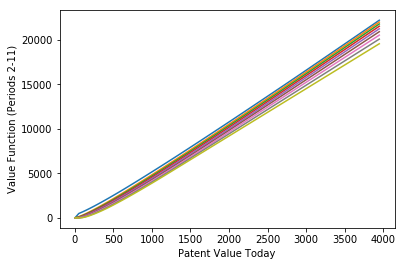

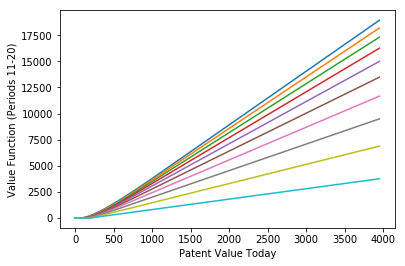

In [7]:
SCHED =  np.array(schedule['sched_1'])
MAX_R = 4000
GRID = 50
STATES = np.array(range(0,MAX_R,GRID))

#graph value function - Schedule 1
V =  memoize_value(sched_1,2,MAX_R,GRID)

#period's 1-9
fig = plt.figure()
for i in range(9):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 2-11)')

#periods 9-18
fig = plt.figure()
for i in range(9,19):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 11-20)');

### Section 3 - Quadratic fee Schedule

Below I calculate the value function and cutoffs for the second schedule using France's parameters

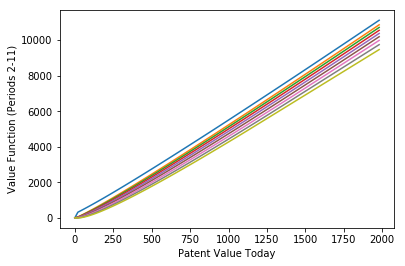

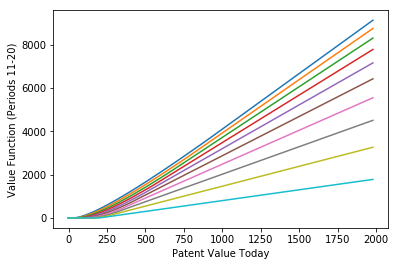

In [8]:
#graph cutoffs function - Schedule 2
SCHED =  np.array(schedule['sched_1'])
MAX_R = 2000
GRID = 20
STATES = np.array(range(0,MAX_R,GRID))

#graph value function - Schedule 1
V =  memoize_value(sched_2,2,MAX_R,GRID)

#period's 1-9
fig = plt.figure()
for i in range(9):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 2-11)')

#periods 9-18
fig = plt.figure()
for i in range(9,19):
    plt.plot(STATES, V[i])
    
plt.xlabel('Patent Value Today')
plt.ylabel('Value Function (Periods 11-20)');

Cutoff Vales: [20, 20, 20, 20, 20, 20, 20, 20, 40, 40, 60, 80, 80, 100, 120, 140, 160, 180, 220]


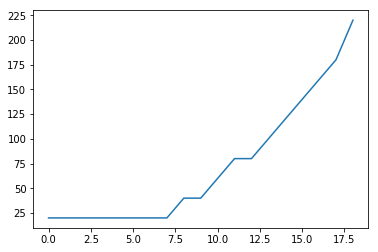

In [9]:
#graph cutoffs function - Schedule 2
cutoffs = find_cutoffs(V)
print 'Cutoff Vales: %s'%cutoffs
plt.plot(cutoffs);

## Section 4 - Comparing Results


We can see that the non-linear fee schedule results in a non-linear graph when compared to the linear fee schedule. When making a patent renewal decision, firms need a lower less expected revenue renew under the non-linear cost schedule. This may increase the number of patent renewals in this market.

Additionally, changing the state space for the linear fee schedule by increasing the maximum $r_a$ to 4000 does not drastically alter the value function.